In [1]:
import numpy as np
from scipy.sparse.linalg import svds
from matplotlib import pyplot as plt
import seaborn as sns
import fastplotlib as fpl
from tqdm import tqdm
from ipywidgets import interact

using: <jupyter_rfb._jpg.SimpleJpegEncoder object at 0x7feac3ccfd50>


In [2]:
toy_shape = (2, 10_000)

In [3]:
p1 = 0.01
pixels = np.random.choice(a=[0, 1], size=toy_shape, p=[1-p1, p1])
pixels[1:] = pixels[0]

# pixels[1] += np.random.choice(a=[0, 1], size=(toy_shape[1]), p=[1-p_noise, p_noise])
pixels[pixels == 2] = 1

for i in range(pixels.shape[0]):
    for j in range(10):
        pixels[i] += np.roll(pixels[i], shift=1)

pixels[pixels > 1] = 1
pixels = pixels.astype(float)
# pixels *= 2

pixels_clean = pixels.copy()

for i in range(pixels.shape[0]):
    pixels[i] += (np.random.normal(0, 1, size=toy_shape[1]) / 2)

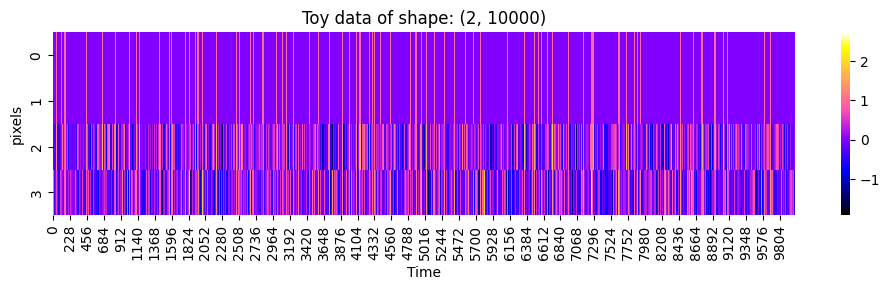

In [4]:
fig = plt.figure(figsize=(10, 3))
sns.heatmap(np.vstack([pixels_clean, pixels]), cmap="gnuplot2")
plt.title(f"Toy data of shape: {toy_shape}")
plt.xlabel("Time")
plt.ylabel("pixels"), pixels
plt.tight_layout()
plt.show()

In [84]:
tau = 10 # 4
max_amp = 1  # just to make saving as uint8 in opencv simple
amps_all = []
num_components = 1
num_frames = 10_000

for component_num in np.arange(num_components):
    amps = []
    amp = 0
    for time_step in np.arange(num_frames):
        if np.random.uniform(0,1) > 0.99:  #0.98
            amp = max_amp
        else:
            amp = np.max(np.array([amp - amp/tau, 0]));
        amps.append(amp)
    amps = np.array(amps)
    amps_all.append(amps), pixels
pixels = np.array(amps_all)
pixels_clean = np.vstack([pixels.copy(), pixels.copy()])

for i in range(pixels.shape[0]):
    pixels[i] += (np.random.normal(0, 1, size=toy_shape[1]) / 5)

pixels = np.vstack([pixels, pixels])

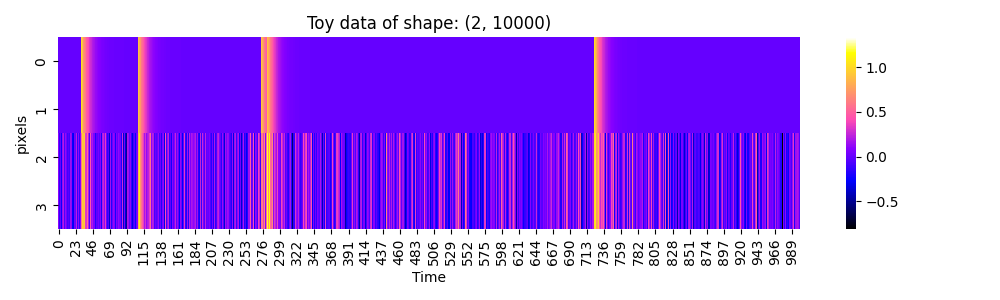

In [85]:
fig = plt.figure(figsize=(10, 3))
sns.heatmap(np.vstack([pixels_clean, pixels])[:, :1_000], cmap="gnuplot2")
plt.title(f"Toy data of shape: {toy_shape}")
plt.xlabel("Time")
plt.ylabel("pixels"), pixels
plt.tight_layout()
plt.show()

In [56]:
class TdSVD:
    def __init__(
        self,
        data: np.ndarray,
        n_time_steps: int,
        delay: int,
    ):
        self.n_time_steps = n_time_steps
        
        n_timepoints = data.shape[1]
        self.n_pixels = data.shape[0]
        
        self.A = np.zeros((self.n_pixels * n_time_steps, n_timepoints - (n_time_steps * delay)), dtype=np.float32)
        
        for pixel_ix in tqdm(range(self.n_pixels)):
            for step in range(n_time_steps):
                self.A[(n_time_steps * pixel_ix) + step] = np.roll(data[pixel_ix], shift=-delay * step)[:-n_time_steps * delay]

        self.k, self.U, self.S, self.V = None, None, None, None
    
    def fit(self, k=6, **kwargs):
        self.k = k
        self.U, self.S, self.V = svds(self.A, k=k, **kwargs)
        self.U = self.U[:, ::-1]
        self.S = self.S[::-1]
        self.V = self.V[::-1, :]

    def get_spatial(self):
        return self.U.reshape(self.n_pixels, self.n_time_steps, self.k)

In [57]:
%matplotlib ipympl

In [58]:
import seaborn as sns

In [74]:
tdsvd = None

In [86]:
@interact(n_time_steps=(1, 25), delay=(1, 50), k=(2, 10))
def plot_everything(n_time_steps: int = 5, delay: int = 1, k: int = 4):
    fig = plt.figure(figsize=(15, 10))
    grid = plt.GridSpec(10, 10)
    
    toy_plot = fig.add_subplot(grid[0, :])
    sns.heatmap(np.vstack([pixels_clean]), cmap="gnuplot2", ax=toy_plot)
    toy_plot.set_title(f"Toy data of shape: {toy_shape}")
    toy_plot.set_xlabel("Time")
    toy_plot.set_ylabel("pixels")

    toy_plot_noise = fig.add_subplot(grid[1:2, :])
    sns.heatmap(np.vstack([pixels]), cmap="gnuplot2", ax=toy_plot_noise)
    toy_plot_noise.set_title(f"Toy data  + noise: {toy_shape}")
    toy_plot_noise.set_xlabel("Time")
    toy_plot_noise.set_ylabel("pixels")

    global tdsvd
    tdsvd = TdSVD(pixels, n_time_steps=n_time_steps, delay=delay)
    tdsvd.fit(k=k)
    
    plot_embed = fig.add_subplot(grid[2:7, :])
    sns.heatmap(tdsvd.A, cmap="gnuplot2", ax=plot_embed)
    plot_embed.set_title(f"Time embedding, shape: {tdsvd.A.shape}, n_steps: {tdsvd.n_time_steps}")
    plot_embed.set_xlabel("Time")
    plot_embed.set_ylabel("pixels over steps")
    
    plot_svals = fig.add_subplot(grid[8:, :3])
    plot_svals.scatter(np.arange(tdsvd.S.size), tdsvd.S / tdsvd.S.max())
    plot_svals.set_yscale("log")
    for x, y in zip(np.arange(tdsvd.S.size), tdsvd.S):
        plot_svals.annotate(f"{y:.2e}", (x + 0.05, y))
    
    plot_svals.set_title(f"Singular values: {np.array2string(tdsvd.S / tdsvd.S.max(), precision=3)}")
    
    plot_u = fig.add_subplot(grid[8:, 3:6])
    img_u = sns.heatmap(tdsvd.U, ax=plot_u, cmap="seismic")
    # fig.colorbar(img_u)
    plot_u.set_title(f"Left singular vectors, shape: {tdsvd.U.shape}")
    
    plot_v = fig.add_subplot(grid[7:, 6:])
    img_v = sns.heatmap(np.vstack([pixels_clean[0, :tdsvd.V.shape[1]] / 10, tdsvd.V]), cmap="seismic", ax=plot_v)
    # fig.colorbar(img_v)
    plot_v.set_title(f"Right singular vectors, shape: {tdsvd.V.shape}")
    
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=5, description='n_time_steps', max=25, min=1), IntSlider(value=1, descri…

In [99]:
%matplotlib inline

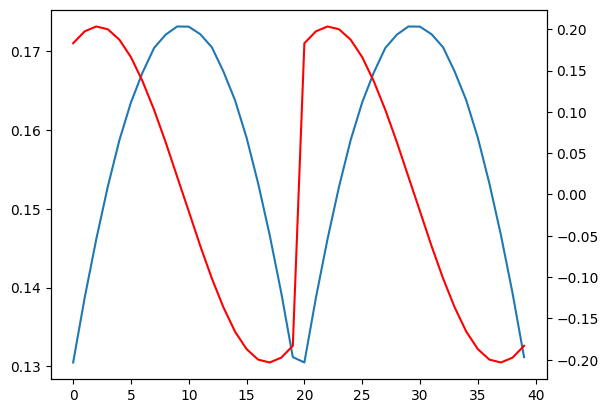

In [112]:
plt.plot(-tdsvd.U[:, 0])
plt.twinx()
plt.plot(-tdsvd.U[:, 1], color="r")

In [87]:
from scipy.linalg import svd

In [88]:
u, s, v = svd(pixels.astype(float))

In [89]:
s / s.max()

array([1.00000000e+00, 4.78800902e-17])

In [90]:
%matplotlib ipympl

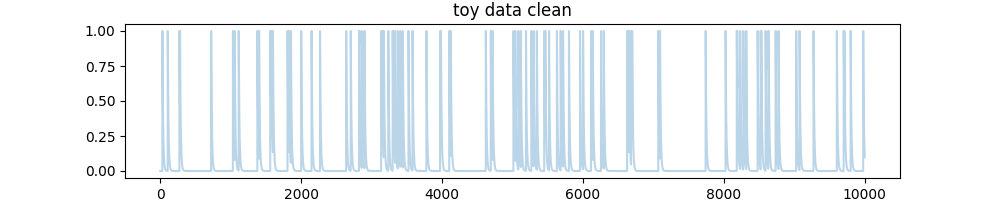

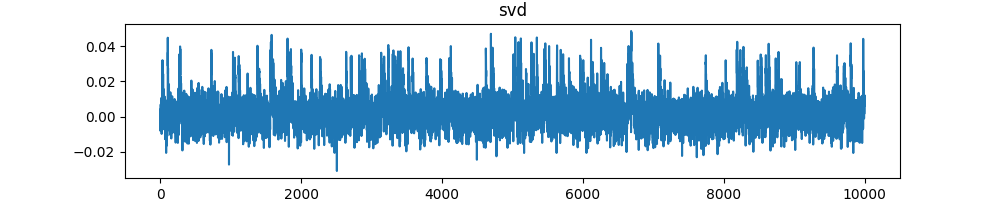

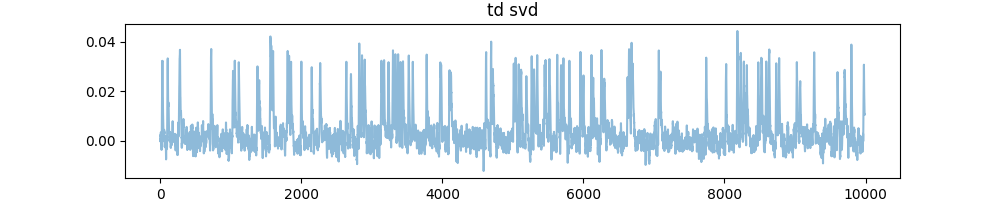

In [93]:
fig = plt.figure(figsize=(10, 2))
plt.plot(pixels_clean.mean(axis=0), alpha=0.3)
plt.title("toy data clean")
plt.show()

fig = plt.figure(figsize=(10, 2))
plt.plot(-v[0])
plt.title("svd")
plt.show()

fig = plt.figure(figsize=(10, 2))
plt.plot(-tdsvd.V[0], alpha=0.5)
plt.title("td svd")
plt.show()

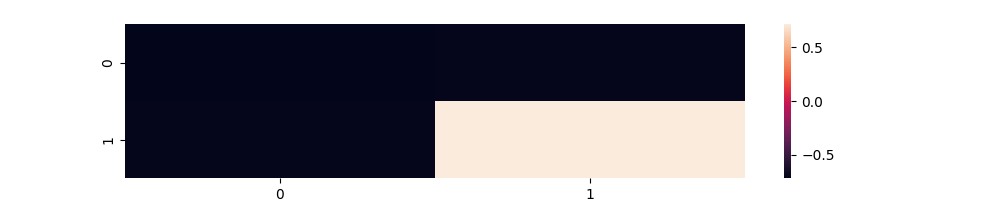

In [90]:
fig = plt.figure(figsize=(10, 2))
sns.heatmap(u)
plt.show()